<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://www.univ-tlse3.fr/" ><img src="http://www.univ-tlse3.fr/medias/photo/ut3pres_logoq_1372757033342.jpg?ID_FICHE=49702" style="float:right; max-width: 250px; display: inline" alt="UPS"/></a> 
</center>



# Biais et Discrimination en Apprentissage Statistique

### Résumé
Analyse de données extraites d'un recensement aux USA de 1994 et disponibles sur le [dépôt de l'UCI](http://archive.ics.uci.edu/ml/). Ces données permettent de mettre en relation le niveau de revenu (inférieur ou supérieur à 50k$) avec d'autres variables dont certaines sensibles car indiquant l'appartenance à un groupe en principe protégé par al loi: genre, origine ethnique. Différents indicateurs de biais donc de sources de discrimination vis à vis d'un groupe sont définis et illustrés sur ces données. Les principaux relativement consensuels dans la littérature sont l'effet disproportionné et l'asymétrie disproportionnée des rapports de cote conditionnels. Les résultats montrent que les biais de société présents dans les données d'apprentissage sont fidèlement reproduits par l'apprentissage et même renforcés. C'est typiquement un cas de de discrimination. Le processus de "testing" ou détection d'un biais individuel est également expérimenté. Enfin deux procédures élémentaires de correction de biais sont expérimentées.

## 1 Introduction
### 1.1 Les données
Des données publiques disponibles sur le site [UCI repository](http://archive.ics.uci.edu/ml/) sont extraites de la base de données issue du recensement réalisé aux Etats Unis en 1994. Ces données son largement utilisées et font référence comme outil de *benchmark* pour comparer les performances de méthodes d’apprentissage. L’objectif est de prévoir, avec plus ou moins de biais, la variable binaire "revenu annuel" supérieur ou inférieur à 50k$. Cette prévision n'impacte pas la personne mais comme la démarche et le contexte sont tout à fait similaires à ce que pourrait faire une banque pour évaluer un risque de crédit, c'est exemple est très illustratif. Il est d'ailleurs systématiquement utilisé pour comparer les propriétés des algorithmes d'apprentissage équitable (*fair learning*) car contrairement à beaucoup d'autres jeux de données utlisés pour cette fin (*e.g. german credit bank*), la vraie valeur de la variable cible est connue ainsique l'origine ethnique des personnes concernées.

Dans les données initiales, 32.561 individus sont décrits par les 14 variables du tableau ci-dessous:


|Num|Libellé|Ensemble de valeurs|
|-|:---------|:-------------------|
|1|`Age`|real|
|2|`workClass`|Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked|
|3|`fnlwgt`|real|
|4|`education`|Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool|
|5|`educNum`|integer|
|6|`mariStat`|Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse|
|7|`occup`|Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces|
|8|`relationship`|Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
|9|`origEthn`|White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black|
|10|`sex`|Female, Male|
|11|`capitalGain`|real| 
|12|`capitalLoss`|real|
|13|`hoursWeek`|real|
|14|`nativCountry`|United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands|
|15|`income`|>50K, <=50K|


### 1.2 Les traitements et analyses réalisés sur ces données
 
- Lecture et prise en charge des données en remarquant que la variable `fnlwgt` (Final sampling weight) a un [statut particulier](http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) pas très clair; elle est éliminée.
- Exploration élémentaire et multidimensionnelle (AFCM) afin de représenter les sources des biais présents.
- Prévision du revenu par régression logistique.
- Estimation du *disparate impact* (effet disproportionné) par intervalle de confiance vis-à-vis de deux variables sensibles: genre et origine ethnique sur les données initiales et sur les prévisions du seuil de revenu.
- Comparaison des asymétries des rapports de cote conditionnels selon les modalités de la variable sensible.
- Evaluation de la sensibilité de ces modèles à des actions de testing: quels sont les individus pour lesquels la prévision du seuil de revenu dépend fortement de la variable sensible.
- Expérimentation des corrections élémentaires des biais détectés par le testing et en biaisant les seuils de décision. 

Parmi tous les critères de biais existant susceptibles de mettre en évidence une discrimination, deux ont été privilégiés: l'effet disproportionné (*disparate impact*) et l'asymétrie disproportionnée des rapports de cote conditionnels ou (*Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds* cf. Vermat et Rubin 2018).

**Remarque** Tout ce qui a été fait en utilisant la régression logistique comme méthode de prévision a également été opéré en utilisant l'algorithme *Random Forest*. Ceci produit les mêmes résultats, c'est-à-dire approximativement les mêmes qualités de prévision, avec une léger bénéfice pour RF, et les mêmes orientations des biais et discrimination. par souci de simplicité et compte tenu de l'objectif, seule la régression logistique est développée ci-dessous. 

## 2 Exploration des données
### 2.1 Lecture et premières transformations
La lecture et la transformation des données brutes du dépôt de l'UCI sont obtenues directement en exécutant un code source en R. Consulter le code du programme pour comprendre les transformations qui ont été réalisées sur les données brutes. Cette étape peut être rendue plus efficace (programme plus concis et exécution plus rapide) en utilisant la librairie `dplyr` très adaptée à cet usage.

Charger les données et le programme dans le répertoire courant en même temps que ce tutoriel ou changer de chemin pour y accéder directement. 

Certaines variables qualitatives sont recodées afin de regrouper des classes à trop faibles effectifs, les variables quantitatives, dont l'âge, sont découpées en classes afin d'en construire des versions qualitatives en vue d'une AFCM.

In [1]:
source("dataPrepAdultCensus.R")
summary(dataBase)

      age                workClass         fnlwgt              education   
 Min.   :18.00   Federal-Govt :  933   Min.   :  13769   HS-grad    :9829  
 1st Qu.:28.00   Not-Working  :   14   1st Qu.: 117627   HS-Graduate:6674  
 Median :37.00   Other-Govt   : 3330   Median : 178487   Bachelors  :5043  
 Mean   :38.68   Private      :21988   Mean   : 189879   Dropout    :3421  
 3rd Qu.:47.00   Self-Employed: 3560   3rd Qu.: 237671   Associates :2315  
 Max.   :90.00                         Max.   :1484705   Masters    :1626  
                                                         (Other)    : 917  
    educNum               mariStat              occup     
 Min.   : 1.00   Married      :14081   Admin       :3698  
 1st Qu.: 9.00   Never-Married: 9394   Blue-Collar :9840  
 Median :10.00   Not-Married  : 5523   Other-occups:1552  
 Mean   :10.16   Widowed      :  827   Professional:4028  
 3rd Qu.:13.00                         Sales       :3498  
 Max.   :16.00                        

### 2.2 Description statistique élémentaire
Mettre en évidence des difficultés présentes sur certaines variables ou couples de variables.

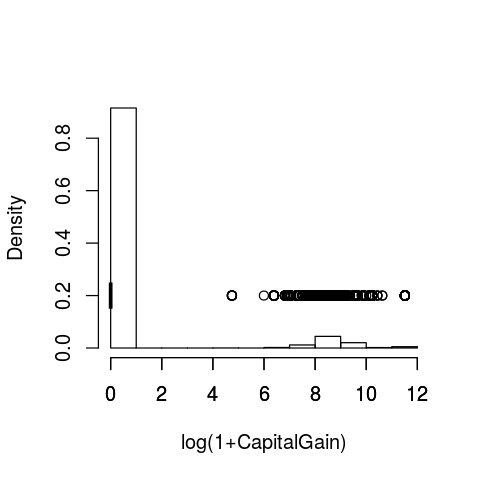

In [2]:
options(repr.plot.width=4, repr.plot.height=4)
hist(dataBase[,"LcapitalGain"],probability=T, main="",xlab="log(1+CapitalGain)")
boxplot(dataBase[,"LcapitalGain"], horizontal=TRUE,boxwex=.2,  outline=TRUE,  
        frame=F, col = "lightgrey", add = TRUE,at=0.2)

Nécessité de transformer certaines variables avant de contruire des modèles linéaires puis mise en évidence d'incohérences et de fortes redondances dans certaines variables.

In [3]:
table(dataBase$relationship,dataBase$sex)   

                
                 Female  Male
  Husband             1 12459
  Not-in-family    3563  4150
  Other-relative    379   493
  Own-child        1825  2343
  Unmarried        2459   747
  Wife             1405     1

In [4]:
table(dataBase$education,dataBase$educNum)  

             
                 1    2    3    4    5    6    7    8    9   10   11   12   13
  Associates     0    0    0    0    0    0    0    0    0    0 1307 1008    0
  Bachelors      0    0    0    0    0    0    0    0    0    0    0    0 5043
  Doctorate      0    0    0    0    0    0    0    0    0    0    0    0    0
  Dropout       45  151  287  554  432  714  894  344    0    0    0    0    0
  HS-grad        0    0    0    0    0    0    0    0 9829    0    0    0    0
  HS-Graduate    0    0    0    0    0    0    0    0    0 6674    0    0    0
  Masters        0    0    0    0    0    0    0    0    0    0    0    0    0
  Prof-School    0    0    0    0    0    0    0    0    0    0    0    0    0
             
                14   15   16
  Associates     0    0    0
  Bachelors      0    0    0
  Doctorate      0    0  375
  Dropout        0    0    0
  HS-grad        0    0    0
  HS-Graduate    0    0    0
  Masters     1626    0    0
  Prof-School    0  542    0

In [5]:
table(dataBase$mariStat,dataBase$relationship)

               
                Husband Not-in-family Other-relative Own-child Unmarried  Wife
  Married         12460            14            118        83         0  1406
  Never-Married       0          4435            532      3632       795     0
  Not-Married         0          2832            182       441      2068     0
  Widowed             0           432             40        12       343     0

In [6]:
table(dataBase$origEthn,dataBase$nativCountry)

             
              British-Commonwealth China Euro_1 Euro_2 Latin-America Other
  Amer-Indian                    0     1      1      2             9     0
  Asian                         88   122      2     71             6    43
  Black                          9     0      7      0           163     6
  Other                          6     0      1      0            84     5
  White                        221     6    213    145           779   139
             
              SE-Asia South-America United-States
  Amer-Indian       1             1           267
  Asian           290             0           272
  Black             1             1          2603
  Other             0            20           111
  White            12           188         23929

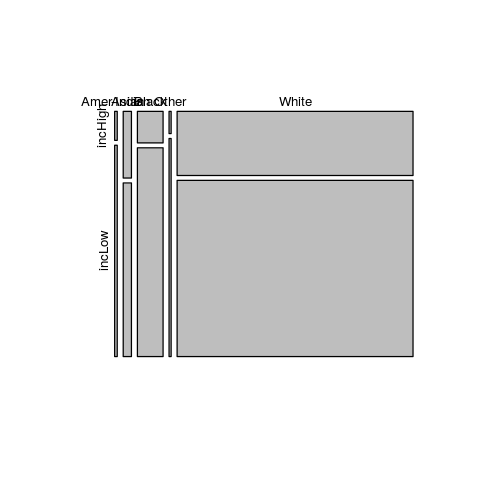

In [7]:
mosaicplot(table(dataBase[,"origEthn"],dataBase[,"income"]),main="")

Quelques modifications sont apportées de la base. Certaines variables en versions quantitatives et qualitatives comme le nombre d'heures par semaine, l'âge ou le niveau d'éducation sont conservées. Des variables sont supprimées afin de ne garder qu'une seule présence d'une information sensible: genre et origine ethnique.
- Suppression de la variable 3 `fnlwgt` qui n'a guère de signification pour cette analyse.
- Création d'une variable binaire `Child`: présence ou non d'enfants.
- Suppression de la variable 8 `relationship` redondante avec le genre et le statut marital,
- Suppression de la variable 14 `nativCountry` redondante avec l'origine ethnique.
- La variable 9 `originEthn` est simplifiée à 2 classes: CaucYes *vs.* CaucNo

**Attention** Pour la suite, il est important que les niveaux des facteurs soient ordonnés de façon cohérente pour la bonne interprétation des tables de contingence et de leurs effectifs. Par convention, les modalités pré-jugées socialement "dévavorables": revenu faible, femme, non caucasien, précèdent les autres (codées 0): revenu élevé, homme, caucasien (codées 1). Il faut donc soit réordonner les niveaux de la variable `income` ou renommer les modalités pour faire correspondre l'ordre alphabétique. Ce deuxième choix est exécuté.

In [8]:
dataBase[,"child"]=as.factor(ifelse(dataBase$relationship=='Own-child',"ChildYes","ChildNo"))
dataBase[,"origEthn"]=as.factor(ifelse(dataBase$origEthn %in% c('Amer-Indian','Asian','Black','Other'),"CaucNo","CaucYes"))
dataBase[,"income"]=as.factor(ifelse(dataBase$income=='incLow',"incB","incH"))
datBas=dataBase[,-c(3,8,14)]
summary(datBas)

      age                workClass           education       educNum     
 Min.   :18.00   Federal-Govt :  933   HS-grad    :9829   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   14   HS-Graduate:6674   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 3330   Bachelors  :5043   Median :10.00  
 Mean   :38.68   Private      :21988   Dropout    :3421   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 3560   Associates :2315   3rd Qu.:13.00  
 Max.   :90.00                         Masters    :1626   Max.   :16.00  
                                       (Other)    : 917                  
          mariStat              occup         origEthn         sex       
 Married      :14081   Admin       :3698   CaucNo : 4193   Female: 9632  
 Never-Married: 9394   Blue-Collar :9840   CaucYes:25632   Male  :20193  
 Not-Married  : 5523   Other-occups:1552                                 
 Widowed      :  827   Professional:4028                                 
                       Sales       :34

Quelques mosaicplots importants montrant le liens des variables sensibles avec la cible (seuil de revenu).

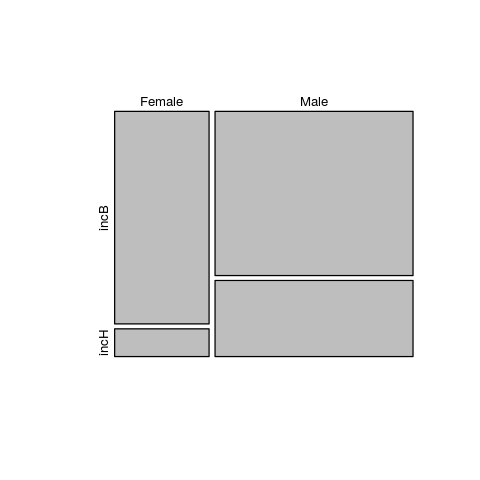

In [9]:
mosaicplot(table(datBas[,"sex"],datBas[,"income"]),main="")

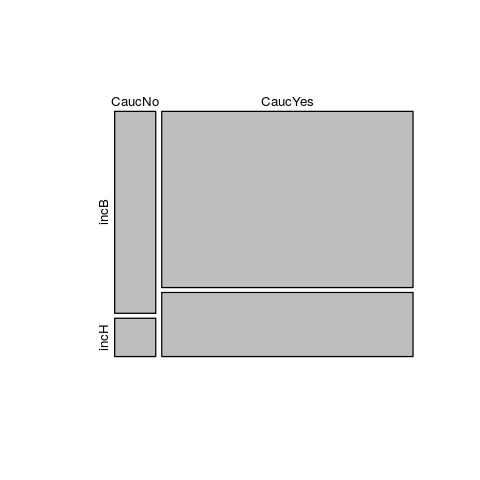

In [10]:
mosaicplot(table(datBas[,"origEthn"],datBas[,"income"]),main="")

**Q** Commentaire sur le biais présent dans la base.

In [11]:
# Sauvegarder la base de données
write.csv(datBas,file="adultBase-R.csv",row.names = FALSE)

### 2.3  [Analyse factorielle multiple des correspondances](http://wikistat.fr/pdf/st-m-explo-afcm.pdf)
Cette méthode permet d'avoir une vue d'ensemble de la structure des liaisons entre les variables qualitatives prises 2 à 2. 

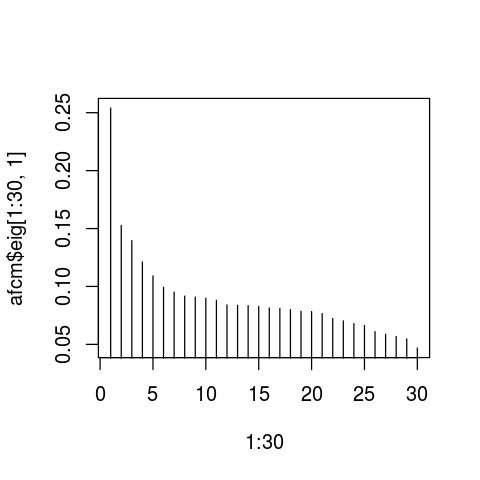

In [12]:
library(FactoMineR)
dataq=datBas[,c(2,3,5:10,12,15:17)]
afcm=MCA(dataq,graph=FALSE)
plot(1:30,afcm$eig[1:30,1],type="h")

Il pourrait être utile de considérer 3 ou 4 axes mais seuls deux sont utilisés dans cette approche élémentaire. 

**Remarque** Cette étape permettrait d'anonymiser les données pour des traitements ultérieurs "confidentiels". Les variables qualitatives suceptibles de ré-identifier les données sont remplacées par les composantes principales de l'ACP des vecteurs profils lignes du tableau disjontif complet. Les liens entre individus sont conservés sans possibilité de les identifier.

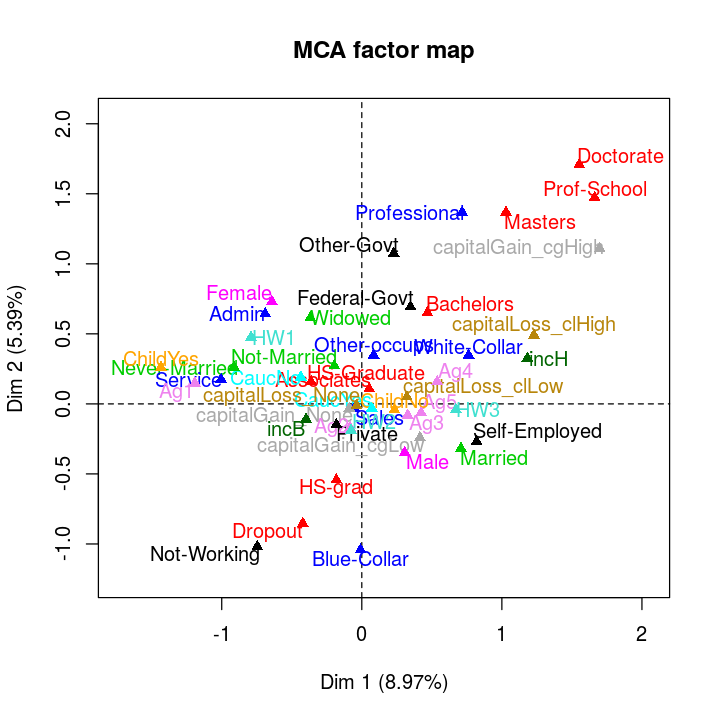

In [13]:
options(repr.plot.width=6, repr.plot.height=6)
plot.MCA(afcm,invisible=c("ind"),habillage="quali")

Remarquer la très forte et attendue liaison entre niveau d'éducation et activité selon un axe de dispersion suivant la première bissectrice lui même en relation avec les modalités haut et bas revenus alors que le genre, en première approximation, semble orthogonal à cet axe mais en relation avec le type d'activité et le nombre d'heures de travail par semaine.

Ce graphique laisse penser que le lien entre genre et niveau de revenu ne serait pas dû à une sous qualification des femmes mais à une moindre activité (travail partiel) ou à des types d'emplois moins rémunérés.

Cette représentation est complétée en projetant les individus colorés selon la variable revenu. De façon triviale, les hauts revenus se concentrent du côté des niveaux d'éducation les plus élevés.

*En résumé*: un lien direct entre revenu et niveau d'éducation, pas nécessairement de lien entre genre et niveau d'éducation mais un "frein" au revenu lié au type de travail ou d'occupation : administratif, service... et à de possibles temps partiels.

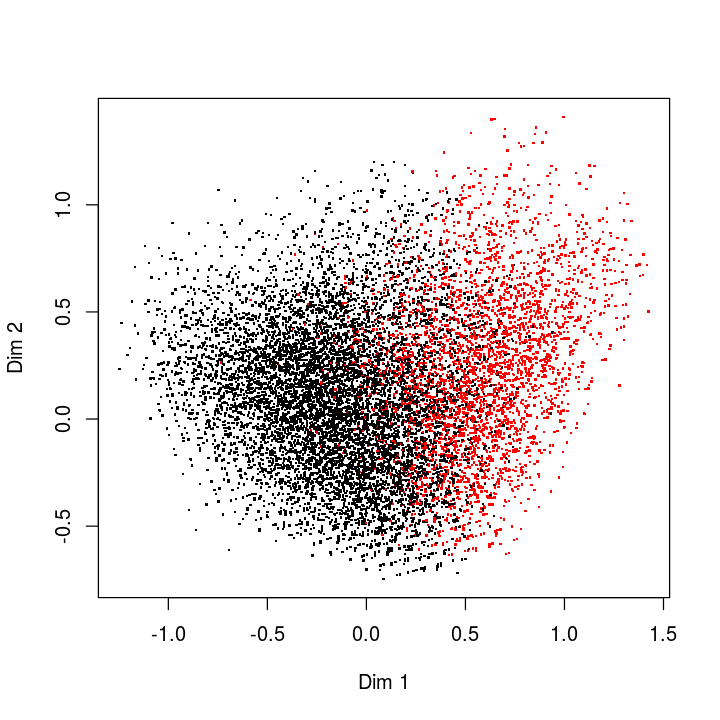

In [14]:
plot(afcm$ind$coord,type="p",pch=".",cex=2,col=as.integer(dataBase$income))

##### 3 Modèles de prévision du seuil de revenu
Une comparaison détaillée (cf. le [tutoriel](https://github.com/wikistat/Apprentissage/blob/master/Adult-Census/Apprent-Python-AdultCensus.ipynb)) de la plupart des modèles et algorithmes de prévision du seuil de revenu en fonction des différentes variables met en évidence des résultats de prévision un peu meilleurs obtenus par l'algorithme de *gradient boosting* (version xtrem). Néanmoins, on peut se limiter ici à un modèle de régression logistique, rapide, compétitif et interprétable. Un arbre de décision seul donne également une précision assez similaire mais beaucoup trop complexe (profondeur) pour être interprétable. 

### 3.1 Echantillons
Les données sont préalablement séparées en deux échantillons: apprentissage et test.

In [15]:
set.seed(111) # initialisation du générateur
# Extraction des échantillons
test.ratio=.2   # part de l'échantillon test
npop=nrow(datBas) # nombre de lignes dans les données
nvar=ncol(datBas) # nombre de colonnes
# taille de l'échantillon test
ntest=ceiling(npop*test.ratio) 
# indices de l'échantillon test
testi=sample(1:npop,ntest)
# indices de l'échantillon d'apprentissage
appri=setdiff(1:npop,testi) 

In [16]:
# construction de l'échantillon d'apprentissage
datApp=datBas[appri,]
# construction de l'échantillon test 
daTest=datBas[testi,]

### 3.2 Prévision par régression logistique
Comme la plupart des coefficients sont significatifs au sens d'un test de Fisher et par souci de simplicité, il n'est pas fait de sélection de modèle ni non plus tenté un modèle avec des interactions. Remarquer que la présence des versions qualitatives (découpage en classe) des variables quantitatives introduit une part de non linéarité dans le modèle par la présence des dindicatrices des classes.

La fonction ci-dessous calcule le taux d'erreur usuel de la matrice de confusion. Avec l'ordonnencement des modalités, les bien classés sont les termes diagonaux de la matrice de confusion.

In [17]:
tauxErr=function(table){round((table[1,2]+table[2,1])/sum(table)*100,2)}

In [18]:
# estimation du modèle complet
log.lm=glm(income~.,data=datApp,family=binomial)
# significativité des paramètres
anova(log.lm,test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,23859,26987.35,NA
age,1,1323.40204,23858,25663.94,9.282513e-290
workClass,4,143.06839,23854,25520.88,6.217805e-30
education,7,2816.95193,23847,22703.92,0.000000e+00
educNum,1,25.85281,23846,22678.07,3.684672e-07
mariStat,3,4102.51916,23843,18575.55,0.000000e+00
occup,6,559.42350,23837,18016.13,1.312883e-117
origEthn,1,14.79769,23836,18001.33,1.196820e-04
sex,1,40.87427,23835,17960.46,1.623445e-10
capitalGain,2,1478.23645,23833,16482.22,1.012835e-321


Remarquer la présence significative et simultanée des variables quantitatives et de leur version qualitative.

In [19]:
# Prévision
pred.log=predict(log.lm,newdata=daTest,type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 4159  551
  TRUE   334  921

In [20]:
tauxErr(confMat)

[1] 14.84

Les qualités de prévision  sont très similaires à celles obtenues par d'autres algorithmes comme les forêts aléatoires.

### 3.3 Modèle de régression sans la variable genre
Une approche naïve pour construire un apprentissage loyal consiste à supprimer la variabl sensible. Le modèle de régression logisitique est donc estimé également dans cette variable afin d'évaluer l'impact sur le biais.

In [21]:
# estimation du modèle sans la variable genre
log_g.lm=glm(income~.,data=datApp[,-8],family=binomial)

In [22]:
# Prévision
pred_g.log=predict(log_g.lm,newdata=daTest[,-8],type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred_g.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 4163  551
  TRUE   330  921

In [23]:
tauxErr(confMat)

[1] 14.77

La qualité de prévision est sensiblement la même.
### 3.4 Régression logistique sans l'origine
Même chose mais sans cette fois la variable d'origine.

In [24]:
# Estimation du modèle sans la variable origine
log_o.lm=glm(income~.,data=datApp[,-7],family=binomial)
# Prévision
pred_o.log=predict(log_o.lm,newdata=daTest[,-7],type="response")
# Matrice de confusion  et erreur
confMat=table(pred_o.log>0.5,daTest$income)
confMat; tauxErr(confMat)

       
        incB incH
  FALSE 4161  553
  TRUE   332  919

[1] 14.84

Même remarque.

## 4 Estimation de l'effet disproportionné
### 4.1 Définition
Les mesures de discrimination indirecte ou de groupe sont basées sur un critère d'effet disproportionné ou *disparate impact* (*DI*) apparu aux USA en 1971 pour détecter des situations discriminatoires à l'embauche (référence). Ce critère est défini par le rapport de deux probabilités. La probabilité de bénéficier d'une situation ou décision favorable (revenu élevé, crédit, emploi, logement...) pour une personne du groupe protégé par la loi: femme ou origine non caucasienne, sur la même probabilité pour une personne de l'autre groupe: homme ou origine caucasienne.

*Notations*: 

- $Y$ est la variable cible ou à expliquer, ici le revenu, $Y=1$ revenu élevé *vs* $Y=0$; 
- $g(X)=\hat{Y}$ le score élevé ou faible ou prévision du revenu, $g(X)=\hat{Y}=0$: prévision d'un revenu faible;
- $S$ est la variable sensible qui désigne le groupe en principe protégé par la loi contre une possible discrimination. Il s'agit ici du genre ou de l'origine ethnique réduite à 2 modalités: caucasien ($S=1$) ou non caucasien ($S=0$). 

L'effet disproportionné mesure une situation de biais de société déjà présent dans la base de données. 
$$DI=\frac{P(Y=1|S=0)}{P(Y=1|S=1)}.$$
Il est estimé à partir des valeurs de la table de contingence croisant les variables $Y$ et $S$ par le rapport:
$$\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$$

Appliqué à la prévision $g(X)=\hat{Y}$ de la variable cible $Y$, il mesure le biais de cette prévision et donc le risque de discrimination opéré par la prévision.

### 4.2 Fonction `dispImp`
Une fonction R calcule le $DI$ et fournit de plus une estimation par intervalle de confiance (Besse et al. 2018) décomposant la fonction de densité de la statistique de test par la *delta method*. Cette fonction a trois arguments:   
- la variable $S$ considérée comme sensible: un facteur à deux niveaux ordonnés "favorable" puis "défavorable";
- la variable cible $Y$ ou sa prévision $g(X)=\hat{Y}$: également un facteur à deux niveaux;
- le risque de l'intervalle de confiance, par défaut 5%.

Elle renvoie les trois estimations $DI$ et $IC_g$, $IC_d$ bornes de l'intervalle de confiance.

In [25]:
source("../Functions/dispImp.R")

### 4.3 Effet disproportionné de la base d'apprentissage
Calculé sur les données initiales, le *disparate impact* ou effet disproportionné met en évidence un biais social fort. Les variables sensibles sont le genre puis l'origine ethnique. La fonction `dispImp` nécessite que les niveaux des facteurs soient dans l'ordre lexicographique: niveaux "défavorable" puis "favorable".

#### Ségrégation vis à vis du genre
Table de contingence croisant $Y$ (revenu) avec $S$ (genre).

In [26]:
tableDI=table(datBas$income,datBas$sex)
tableDI

      
       Female  Male
  incB   8520 13798
  incH   1112  6395

*Estimation ponctuelle* de $DI=\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$

In [27]:
round((tableDI[2,1]/(tableDI[1,1]+tableDI[2,1]))/(tableDI[2,2]/(tableDI[1,2]+tableDI[2,2])),3)

[1] 0.365

*Estimation par intervalle de confiance* approché par *delta method*. 

In [28]:
round(dispImp(datBas[,"sex"],datBas[,"income"]),3)

[1] 0.343 0.365 0.386

*Estimation bootstrap de l'intervalle de confiance*

L'estimation approchée par la *delta method* est comparée à une estimation bootstrap de l'intervalle de confiance. En effet, l'estimation du *DI* est instable mais les estimations sur des échantillons bootstrap restent bien dans la zone de risque contrôlée par l'intervalle de confiance. 

In [29]:
B=1000 
set.seed(11)
n=nrow(datBas)
res=matrix(0,B,3)
for (i in 1:B)
    {
    boot=sample(n,n,replace=T)
    res[i,]=dispImp(datBas[boot,"sex"],datBas[boot,"income"])
    }

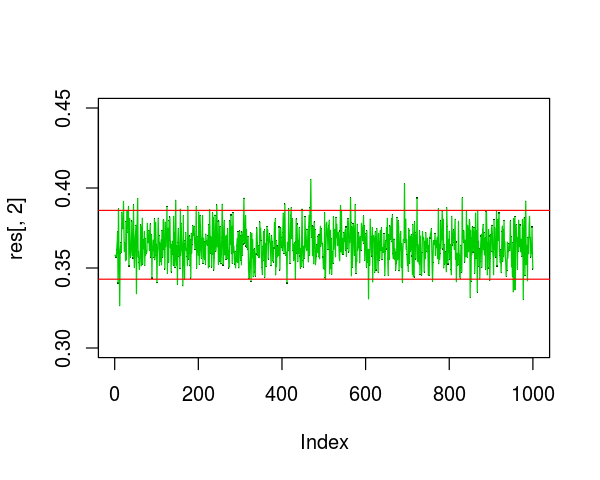

In [30]:
options(repr.plot.width=5, repr.plot.height=4)
plot(res[,2],ylim=c(0.3,0.45),pch='.')
lines(res[,2],col=3,pch='.')
abline(h=0.343,col=2)
abline(h=0.386,col=2)

Une fonction de la librairie `boot` fournit une estimation bootstrap de l'intervalle de confiance.

In [31]:
library(boot)
fc <- function(d, i){ 
    d2 <- d[i,]
    return(statistic=dispImp(d2$sex,d2$income)[2])
}
set.seed(11)
bootDI <- boot(datBas,fc, R=1000)
bootDI


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = datBas, statistic = fc, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.3645429 -2.375429e-05  0.01082264

In [32]:
boot.ci(boot.out = bootDI, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootDI, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 0.3440,  0.3864 )  
Calculations and Intervals on Original Scale

Comme supposé, l'intervalle de confiance issu de l'approximation par *delta method*: $[0.343, 0.386]$ se confond avec  celui obtenu par estimation bootstrap: $[0.344, 0.386]$.

Compte tenu des temps de calcul, l'estimation approchée de l'IC par *delta method* est à privilégier!

#### Biais vis à vis de l'origine: caucasienne *vs.* autre. 

In [33]:
round(dispImp(datBas$origEthn,datBas$income),3)

[1] 0.555 0.598 0.641

Biais nettement plus important selon le genre que selon l'origine ethnique.

### 4.4 Effet disproportionné des prévisions par régression logistique
Le même ratio ou impact disproportionné calculé sur les prévisions $g(X)$ de $Y$ plutôt que sur $Y$ mesure explicitement l'effet de la prévision. Il revient à évaluer l'égalité des taux de prévision favorable. 

La valeur seuil de la probabilité de dépassement du seuil de revenu est fixée par défaut à 0.5.

In [34]:
Yhat=as.factor(pred.log>0.5)

#### Avec régression logistique et par genre
La prévision reproduit et même renforce significativement le biais social pour le genre; les intervalles de confiance sont disjoints.

In [35]:
round(dispImp(daTest[,"sex"],Yhat),3)

[1] 0.212 0.255 0.298

#### Avec régression logistique et par origine
Le renforcement du biais selon l'origine n'est pas statistiquement significatif.

In [36]:
round(dispImp(daTest[,"origEthn"],Yhat),3)

[1] 0.416 0.511 0.607

### 4.5 Effet disproportionné des prévisions sans la variable sensible
Une approche très naïve de réduction de la discriminaiton consisterait à supprimer du modèle la variable sensible.
#### En supprimant la variable genre

In [37]:
Yhat_g=as.factor(pred_g.log>0.5)
round(dispImp(daTest[,"sex"],Yhat_g),3)

[1] 0.226 0.270 0.315

#### En supprimant la variable origine

In [38]:
Yhat_o=as.factor(pred_o.log>0.5)
round(dispImp(daTest[,"origEthn"],Yhat_o),3)

[1] 0.461 0.561 0.662

De même que les erreurs de prévisions restent stables, l'effet disproportionné n'est pas statistiquement affecté par la suppression de la variable sensible. Le déterminisme social est plus fort que la présence de la variable sensible: *une femme ou une personne non caucasienne travaille de toute façon moins ou de façon moins qualifiée quelque soit son niveau d'éducation*. La suppression de la variable sensible n'impacte donc pas la modélisation. 

### 4.6 Correction élémentaire du biais
La suppression de la variable sensible ne corrige pas le biais. Une façon élémentaire de le faire, même si elle peut être jugée déloyale consiste à intervenir sur les seuils de décisions. Par défaut, ce seuil est fixé à 0.5 pour affecter la prévision à la classe. Il suffit de le modifier conditionnellement aux niveaux de la varible sensible pour intervenir directement sur le biais. 

Ainsi, un seuil de 0.35 pour les femmes permet de retrouver une valeur de $DI$ identique à celle des données de la base sans pour autant que le taux d'erreur en soit affecté.

In [39]:
Yhat_cs=as.factor(ifelse(daTest$sex=="Female",pred.log>0.35,pred.log>0.5))
round(dispImp(daTest[,"sex"],Yhat_cs),3)
tauxErr(table(Yhat_cs,daTest$income))

[1] 0.30 0.35 0.40

[1] 14.8

Une réduction plus marquée permet de restreindre significativement le biais avec $0.8\in IC$ mais en dégradant l'erreur de prévision.

In [40]:
Yhat_cs=as.factor(ifelse(daTest$sex=="Female",pred.log>0.15,pred.log>0.5))
round(dispImp(daTest[,"sex"],Yhat_cs),3)
tauxErr(table(Yhat_cs,daTest$income))

[1] 0.669 0.743 0.817

[1] 16.38

Même chose pour l'origine ethnique avec une correction plus légère du seuil.

In [41]:
Yhat_co=as.factor(ifelse(daTest$origEthn=="CaucNo",pred.log>0.4,pred.log>0.5))
round(dispImp(daTest[,"origEthn"],Yhat_co),3)
tauxErr(table(Yhat_co,daTest$income))

[1] 0.518 0.623 0.728

[1] 14.72

**Remarques**: 
- Une approche déontologique *a minima* d'un point de vue statistique consisterait à corriger le seuil pour retrouver la valeur de $DI$ et donc le biais présent dans la base d'apprentissage; corriger plus serait un choix politique pour introduire de la discriination positive.
- Cette approche utilisée par exemple dans les universités américaines pour mieux "équilibrer" les admissions des étudiants selon leur origine pose quelques problèmes. Elle est attaquée en justice notamment pas les candidats d'origine asiatique qui se considère lésés. Pour certains auteurs il s'agit d'une approche *unfair by design*.  

## 5 Biais sur les erreurs ou précisions de prévision
L'effet disproportionné est une première source de biais ou de discrimination parmi bien d'autres. Une deuxième souvent évoquée concerne les erreurs de prévision ou leurs précisions; c'est l'*overall accuracy equality*.
### 5.1 Précision selon la variable sensible

In [42]:
apply(table(pred.log<0.5,daTest$income,daTest$sex),3,tauxErr)

Female   Male 
 92.48  81.56

In [43]:
apply(table(pred.log<0.5,daTest$income,daTest$origEthn),3,tauxErr)

CaucNo CaucYes 
  89.82   84.33

Selon l'origine et surtout pour le genre, les précisions de la prévision sont très différentes mais au détriment du groupe "majoritaire", incluant sans doute plus de disparités et donc de difficultés à être prédit.

Une estimation par intervalle de confiance des rapports de ces quantités serait bienvenue.

## 5.2 Asymétrie de la matrice de confusion
Une autre source de discrimination, mise en évidence par le site [Propublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) à propos du score de récidive, concerne une inversion de l'asymétrie de la matrice de confusion selon la variable sensible. De très nombreux critères ont été proposés pour évaluer cette asymétrie et dont [Verma et Rubin (2018](http://fairware.cs.umass.edu/papers/Verma.pdf)) proposent une synthèse. Leur définitions sont basées sur les différentes fréquences issues de la table de contingence et calculées par la fonction ci-dessous.

In [44]:
contRatio <- function(T){ 
    # Ratios calculés à partir de la matrice de confusion
    TP=T[2,2] # true positive
    FP=T[1,2] # false positive
    FN=T[2,1] # false negative
    TN=T[1,1]  # true negative
    PPV=TP/(TP+FP) # P(Y=1|g(x)=1) positive predictive value
    FDR=FP/(TP+FP) # P(Y=0|g(x)=1) false discovery rate 
    FOR=FN/(TN+FN) # P(Y=1|g(x)=0) false omission rate
    NPV=TN/(TN+FN) # P(Y=0|g(x)=0) negative predictive value
    TPR=TP/(TP+FN) # P(g(x)=1|Y=1) true positive rate
    FPR=FP/(FP+TN) # P(g(x)=1|Y=0) false positive rate
    FNR=FN/(TP+FN) # P(g(x)=0|Y=1) false negative rate
    TNR=TN/(FP+TN) # P(g(x)=0|Y=0) true negative rate
    return(list("PPV"=PPV,"FDR"=FDR,"FOR"=FOR,"NPV"=NPV,"TPR"=TPR,"FPR"=FPR,"FNR"=FNR,"TNR"=TNR))
}

In [45]:
contRatio(table(pred.log>0.5,daTest$income))

$PPV
[1] 0.6256793

$FDR
[1] 0.3743207

$FOR
[1] 0.07433786

$NPV
[1] 0.9256621

$TPR
[1] 0.7338645

$FPR
[1] 0.1169851

$FNR
[1] 0.2661355

$TNR
[1] 0.8830149

Liste de critères de loyauté pouvant être définis à partir des fréquences précédentes conditionnellement à la variable sensible. Selon les auteurs, il y a loyauté de traitement si:
- *Predictive parity*: les deux groupes ont les mêmes *PPV*s et par conséquence les mêmes *FDR*s;
- *False positive error rate balance* ou *predictive equality*: mêmes *FPR*s et par conséquence les mêmes *TNR*s;
- *False negative error rate balance* ou *equal opportunity*: mêmes *FNR*s et par conséquence les mêmes *TPR*s;
- *Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds* combine les deux ci-dessus: mêmes *TPR*s **ET** mêmes *FPR*s;
- *Conditionnal use accuracy equality*: mêmes *PPV*s **ET** mêmes *NPV*s;
- *Teatment equality*: les rapports *FN/FP* sont les mêmes pour les deux groupes.

D'autres critères ont été proposés (cf. Verma et Rubin; 2018), il ne sont pas développés ici.

#### Par genre
La matrice de confusion est obtenue conditionnellement aux groupes pour comparer les différents indicateurs de loyauté.

In [46]:
fairness=data.frame("Female"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,1])),
                    "Male"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,2])))
fairness

,Female,Male
PPV,0.4827586,0.6524194
FDR,0.5172414,0.3475806
FOR,0.01612903,0.1109902
NPV,0.983871,0.8890098
TPR,0.8,0.7255605
FPR,0.06564551,0.1495489
FNR,0.2,0.2744395
TNR,0.9343545,0.8504511


Il n'est pas simple de comparer toutes ces quantités. Il apparaît néanmoins que les taux de faux positifs (FPR) sont nettement en faveur des hommes; il y a certes plus d'erreurs à leur encontre mais, c'est à leur avantage. Ceci peut être mis en évidence par le critère de *conditional procedure accuracy equality* ou encore en considérant l'asymétrie disproportionnée des rapports de cote conditionnels.

#### Par origine

In [47]:
fairness2=data.frame("CaucNo"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$origEthn)[,,1])),
                    "CaucYes"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$origEthn)[,,2])))
fairness2

,CaucNo,CaucYes
PPV,0.5448276,0.6345139
FDR,0.4551724,0.3654861
FOR,0.0342556,0.08248527
NPV,0.9657444,0.9175147
TPR,0.752381,0.7321739
FPR,0.08260325,0.1240092
FNR,0.247619,0.2678261
TNR,0.9173967,0.8759908


Même remarque mais à un degré moindre.

Le critère en question: comparaison des taux de faux positifs peut être précisé en estimant leur rapport par un intervalle de confiance. C'est l'objet de la fonction `OverallAccuracyEquality` qui admet 5 paramètres:
- X: matrice X de caleurs binaires
- S: index de la variable du groupe protégé
- Y: index de la variable cible
- P: index de la prévision $\hat{Y}$

In [48]:
source('../Functions/OverallAccuracyEquality.R')

L'utilisation de cette fonction nécessite de reconfigurer les données.

In [49]:
# Variable genre rendue entière: 0, 1
s1= as.integer(datBas[,8])-1
# variable origine ethnique rendue entière 0, 1
s2= as.integer(datBas[,7])-1
# Variable cible ou décision (seuil de revenu) également entière: 0, 1
Y=as.integer(datBas$income)-1
Yhat=as.numeric(pred.log>0.5)
coded_data1=data.frame(s1[testi],s2[testi],Yhat,as.integer(daTest$income)-1)

In [50]:
summary(coded_data1)

   s1.testi.        s2.testi.           Yhat       
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:1.0000   1st Qu.:0.0000  
 Median :1.0000   Median :1.0000   Median :0.0000  
 Mean   :0.6701   Mean   :0.8484   Mean   :0.2104  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:0.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
 as.integer.daTest.income....1
 Min.   :0.0000               
 1st Qu.:0.0000               
 Median :0.0000               
 Mean   :0.2468               
 3rd Qu.:0.0000               
 Max.   :1.0000               

In [51]:
OAE(coded_data1,1,3,4)

,inf,est_value,sup
TP,1.002978,1.102596,1.202214
TN,1.077184,1.098658,1.120131


In [52]:
0.752381/0.7321739; 0.9173967/0.8759908

[1] 1.027599

[1] 1.047268

**Attention** Les valeurs sont proches mais pas exactement les mêmes... chercher l'erreur!

In [53]:
source('../Functions/ConditionalUseEquality.R')

In [54]:
CUAE(coded_data1,1,3,4)

,inf,est_value,sup
Y=0/f(X)=1,1.27109286,1.4881190,1.705145
Y=1/f(X)=0,0.08976584,0.1453194,0.200873


## 6  *Testing* et détection de discrimination individuelle
### 6.1 Introduction

#### [Historique](https://fr.wikipedia.org/wiki/Test_de_discrimination)
Depuis 1939 en France pour les boîtes de nuit.

#### [Validité juridique](https://www.juritravail.com/discrimination-physique/embauche/ph-alternative-A-1.html) 
Le *testing* accepté comme preuve de discrimiantion depuis 2016.

#### Approches sociologiques 
Le test de discrimination ou *testing* automatique est pratiquée en France de façon systématique pour des études sociologiques par l'[Observatoire des discriminations](http://www.observatoiredesdiscriminations.fr/testing), le laboratoire TEPP: [L'Horty et al. (2017)](http://www.tepp.eu/doc/users/268/bib/banque-et-assurance_9025.pdf), ou pilotée par la [DARES](http://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/etudes-et-syntheses/dares-analyses-dares-indicateurs-dares-resultats/testing) du ministère du travail en lien avec l'association [ISM Corum](http://www.ismcorum.org/).... Certains entreprises demandent d'ailleurs à ISM Corum de [tester leur mode de recrutement](http://www.ismcorum.org/le-testing-d-entreprise-%E2%80%93-temoignages-d-adecco-casino-lvmh-michael-page-M22-R22-A443.html). Il serait sans doute intéressant de disposer des données brutes sur l'enquête citée mais seules les [tableaux agrégés](http://dares.travail-emploi.gouv.fr/IMG/xls/donnees_a_telecharger-_dares_analyses_no076.xls) sont accessibles. 

*Remarques*: des groupes à contacter?
- l'observatoire des discriminations propose un [audit qualité](http://www.observatoiredesdiscriminations.fr/diagnostics-qualite) des procédures de recrutement. 
- [Novethic](https://www.novethic.fr/lexique/detail/testing.html), filliale de la caisse des dépôts et consignation, donnent des formations pour des entreprises "éthiques".

#### *Testing* et estimation du biais
Dans un autre ordre d'idée, [Galhotra et al. (2017)](https://arxiv.org/abs/1709.03221) définissent le biais d'une décision en incluant une notion de causalité. Le logiciel afférent ([Themis](https://github.com/LASER-UMASS/Themis)) opère un *testing* de logiciels ou décisions automatiques dans le but d'évaluer les proportions d'individus virtuels discriminés permettant d'estimer ce critère de biais. Les individus virtuels sont générés par permutation aléatoire des valeurs prises pour les modalités des variables explicatives nécessairement qualitatives ou découpées en classe.

#### *Testing* rudimentaire
Analysons la robustesse des deux modèles à une opération de *testing* rudimentaire: un nouvel échantillon test est construit en *échangeant les deux modalités de la variables sensible*. La variable cible (seuil de revenu) est ensuite reprédite par le modèle initial donné. 

*Question*: Des prévisions sont elles modifiées et pour quels individus?

**Existe-t-il des personnes pour lesquelles le seul changement de genre ou d'origine a pour effet de changer la prévision du seuil de revenu `income`?**

C'est en effet parmi ces personnes de l'échantillon test que se trouvent celles discriminées par la décision apprise et donc susceptibles d'une action en justice lorsque la décision algorihtmique (*e.g.* accès au crédit, à l'assurance, à l'emploi...) impacte cette personne. Cette discrimination individuelle peut en effet peut en effet être mise en évidence contrairement à la discrimination vis à vis d'un groupe dont il n'existe pas de définition ou de caractérisation. 

Evidemment, comme pour l'estimation du *disparate impact*, il est nécessaire de disposer de la variable sensible (genre ou origine) pour pouvoir opérer du *testing*.


### 6.2 Personnes discriminées selon leur genre
#### Modification de l'échantillon et prévisions.

In [55]:
daTest2=daTest
# Changement de genre
daTest2$sex=as.factor(ifelse(daTest$sex=="Male","Female","Male"))
# Prévision du "nouvel" échantillon test
pred2.log=predict(log.lm,daTest2,type="response")

In [56]:
table(pred.log<0.5,pred2.log<0.5)

       
        FALSE TRUE
  FALSE  1171   84
  TRUE     10 4700

Même chose mais répartition par genre.

In [57]:
table(pred.log<0.5,pred2.log<0.5,daTest$sex)

, ,  = Female

       
        FALSE TRUE
  FALSE   140    0
  TRUE     10 1818

, ,  = Male

       
        FALSE TRUE
  FALSE  1031   84
  TRUE      0 2882


**N.B.** Il y a 94 personnes dont la prévision de revenu change lorsqu'elles changent de genre. Et le changement est dans le sens attendu.
- 10 femmes passent d'une prévision de revenu faible à une prévision de revenu élevé
- 84 hommes prennnent le chemin inverse (discrimination initiale positive) lorsqu'ils deviennent des femmes.

### 6.3 Personnes discriminées selon leur origine
Mêmes calculs vis-à-vis de la variable sensible origine.
#### Modification de l'échantillon et prévisions

In [58]:
daTest3=daTest
daTest3$origEthn=as.factor(ifelse(daTest$origEthn=="CaucYes","CaucNo","CaucYes"))
# Prévision du "nouvel" échantillon test
pred3.log=predict(log.lm,newdata=daTest3,type="response")

#### Dans le cas de la régression logisitique
Comme pour la discrimination selon le genre, la détection de personnes discriminées selon leur origine est nette. Les prévisions de seuil de revenu de 160 personnes sont affectées par le changement d'origine.
- 12 sont discriminées par leur origine
- 148 bénéficient d'une discrimination positive

In [59]:
table(pred.log<0.5,pred3.log<0.5)

       
        FALSE TRUE
  FALSE  1107  148
  TRUE     12 4698

In [60]:
table(pred.log<0.5,pred3.log<0.5,daTest$origEthn)

, ,  = CaucNo

       
        FALSE TRUE
  FALSE   105    0
  TRUE     12  787

, ,  = CaucYes

       
        FALSE TRUE
  FALSE  1002  148
  TRUE      0 3911


### 6.4 *Testing* et prévision "loyale" 
Pour la régession logistique, fixer comme probablité prédite le maximum des deux probablités obtenues en échangeant les modalités de la variable sensible. De façon générale, choisir la situation la plus favorable pour la personne quelque soit le genre (resp. l'origine) observé. La discimination individuelle repérable par *testing* est neutralisée et l'influence sur le taux d'erreur quasi négligeable. 

#### Genre

In [61]:
fairPredictGenre=ifelse(pred.log<pred2.log,pred2.log,pred.log)
confMat=table(fairPredictGenre>0.5,daTest$income)
confMat;tauxErr(confMat)

       
        incB incH
  FALSE 4154  546
  TRUE   339  926

[1] 14.84

In [62]:
tableDI=table(fairPredictGenre>0.5,daTest$sex)
tableDI;(tableDI[2,1]/(tableDI[1,1]+tableDI[2,1]))/(tableDI[2,2]/(tableDI[1,2]+tableDI[2,2]))

       
        Female Male
  FALSE   1818 2882
  TRUE     150 1115

[1] 0.2732282

In [63]:
tableDI=table(pred.log>0.5,daTest$sex)
tableDI;(tableDI[2,1]/(tableDI[1,1]+tableDI[2,1]))/(tableDI[2,2]/(tableDI[1,2]+tableDI[2,2]))

       
        Female Male
  FALSE   1828 2882
  TRUE     140 1115

[1] 0.2550129

La correction par *testing* réduit un peu le biais mais de façon insuffisante pour réduire globalement la discrimination.

#### Origine

Des résulats simiulaires sont obtenus.

In [64]:
fairPredictOrig=ifelse(pred.log<pred3.log,pred3.log,pred.log)
confMat=table(fairPredictOrig>0.5,daTest$income)
confMat;tauxErr(confMat)

       
        incB incH
  FALSE 4153  545
  TRUE   340  927

[1] 14.84

In [65]:
tableDI=table(fairPredictOrig>0.5,daTest$origEthn)
tableDI;round((tableDI[2,1]/(tableDI[1,1]+tableDI[2,1]))/(tableDI[2,2]/(tableDI[1,2]+tableDI[2,2])),2)

       
        CaucNo CaucYes
  FALSE    787    3911
  TRUE     117    1150

[1] 0.57

In [66]:
tableDI=table(pred.log>0.5,daTest$origEthn)
tableDI;round((tableDI[2,1]/(tableDI[1,1]+tableDI[2,1]))/(tableDI[2,2]/(tableDI[1,2]+tableDI[2,2])),2)

       
        CaucNo CaucYes
  FALSE    799    3911
  TRUE     105    1150

[1] 0.51

La correction qui rend la décision localement loyale c'est-à-dire en supprimant tout discrimination individuelle n'a qu'un impact très marginal sur l'erreur de prévision. Cette "correction" du biais permet d'échapper à une poursuite juridique individuelle mais ne corrige globalement pas l'effet disproportioné et donc le biais de groupe. Cette correction est factice et pour le moins déloyale. 

D'autres corrections sont à mettre en oeuvre pour conduire à de l'apprentissage loyal et donc à une IA éthique.

## Conclusion
En résumé, 

En France, comme en Europe, il y a donc une part d'hypocrisie à interdire l'enregistrement d'une variable sensible. Certes cela protège la confidentialité des personnes mais empêche aussi de mettre en évidence simplement biais et discriminaiton des traitements. 

Ces dernières questions abordent celle de correction du biais et donc l'objectif d'éviter une discrimination ou tout du moins, a *minima*, que le modèle ou l'algorithme évite une sur-discrimination tout à fait déloyale. Une littérature importante aborde ce sujet. Ce sera l'objet du tutoriel suivant.

## Références
Besse P. ,del Barrio E., Gordaliza P., Loubes J.-M. (2018-a). Confidence Intervals for testing Disparate Impact in Fair Learning, [arXiv](https://arxiv.org/abs/1807.06362).

Verma S., Rubin J. (2018). [Fairness Definitions Explained](http://fairware.cs.umass.edu/papers/Verma.pdf),  ACM/IEEE International Workshop on Software Fairness.